## Part1

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import seaborn as sns

In [5]:
# Initialize an empty dictionary to store the loaded .npz files
data_dict = {}

# Iterate over all files in the extracted directory
for file in os.listdir("../data/"):
    if file.endswith(".npz"):  
        file_path = os.path.join("../data/", file)  
        data = np.load(file_path)  
        # Store the data as a dictionary with keys corresponding to the file's variables
        data_dict[file] = {name: data[name] for name in data.files}

data_dir = "../data/"

# List of specific labeled files to process
labeled_files = ["O013257.npz", "O013490.npz", "O012791.npz"]

images_long = []

# Load and process each labeled file
for file in labeled_files:
    file_path = os.path.join(data_dir, file)  
    data = np.load(file_path)
    images_long.append(data['arr_0']) 
    # Print the shape of the extracted data
    print(f"Shape of {file}: {data['arr_0'].shape}")  
    
# Combine all extracted image arrays into a single NumPy array
total_data = np.vstack(images_long)

# Print the shape of the combined dataset
print("\nShape of combined data (images_long):", total_data.shape)


Shape of O013257.npz: (115000, 11)
Shape of O013490.npz: (115032, 11)
Shape of O012791.npz: (114973, 11)

Shape of combined data (images_long): (345005, 11)


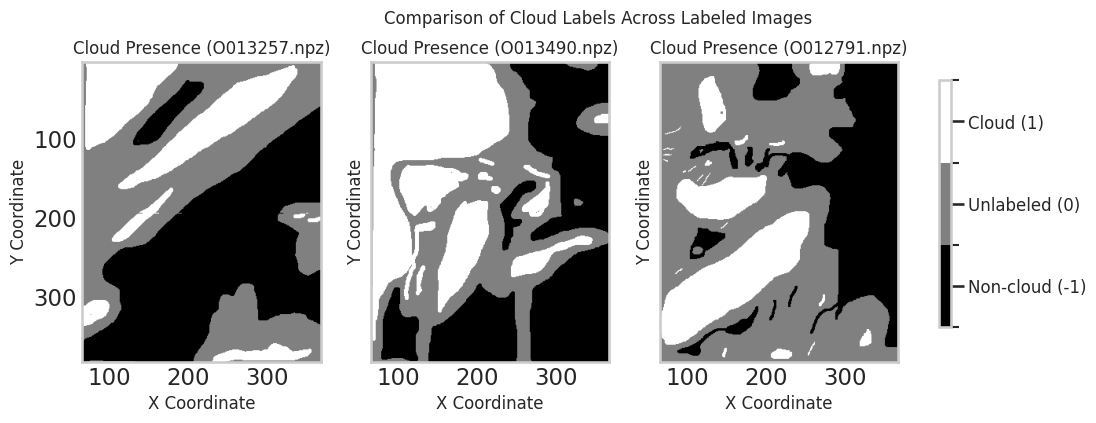

In [47]:
# Define colors for different labels
cloud_color = "white"
unlabeled_color = "grey"
non_cloud_color = "black"

# Create a figure with 3 subplots (one for each labeled image)
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

# Loop through each labeled file and plot in separate subplots
for i, file in enumerate(labeled_files):
    data_path = os.path.join(data_dir, file)
    data = np.load(data_path)
    arr = data["arr_0"]

    # Extract X and Y coordinates, and corresponding labels
    x, y, labels = arr[:, 1], arr[:, 0], arr[:, 10]

    # Create a blank grid to plot
    x_unique = np.unique(x)
    y_unique = np.unique(y)

    # Initialize a blank grid to store label data
    label_grid = np.zeros((len(y_unique), len(x_unique)))

    # Map the labels to the grid
    for j in range(len(x)):
        x_idx = np.where(x_unique == x[j])[0][0]
        y_idx = np.where(y_unique == y[j])[0][0]
        label_grid[y_idx, x_idx] = labels[j]

    # Plot the labels as a heatmap to maintain the same style
    cmap = plt.cm.colors.ListedColormap([non_cloud_color, unlabeled_color, cloud_color])
    bounds = [-1.5, -0.5, 0.5, 1.5]  # Define boundaries for labels
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

    im = axes[i].imshow(
        label_grid, cmap=cmap, norm=norm, extent=[x.min(), x.max(), y.max(), y.min()]
    )

    # Set title for each subplot
    axes[i].set_title(f"Cloud Presence ({file})", fontsize=12)
    axes[i].set_xlabel("X Coordinate", fontsize=12)
    axes[i].set_ylabel("Y Coordinate", fontsize=12)

    # Turn off gridlines
    axes[i].grid(False)

    # Adjust ticks
    axes[i].tick_params(axis='both', which='both', length=0)  # Remove ticks

# Set a common title for all subplots
fig.suptitle("Comparison of Cloud Labels Across Labeled Images", fontsize=12)

# Add a color legend for label interpretation
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation="vertical", shrink=0.8, pad=0.02)
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(["Non-cloud (-1)", "Unlabeled (0)", "Cloud (1)"], fontsize=12)

# Adjust layout for better spacing
plt.subplots_adjust(left=0.05, right=0.75, bottom=0.1, top=0.85, wspace=0.1)
plt.show()


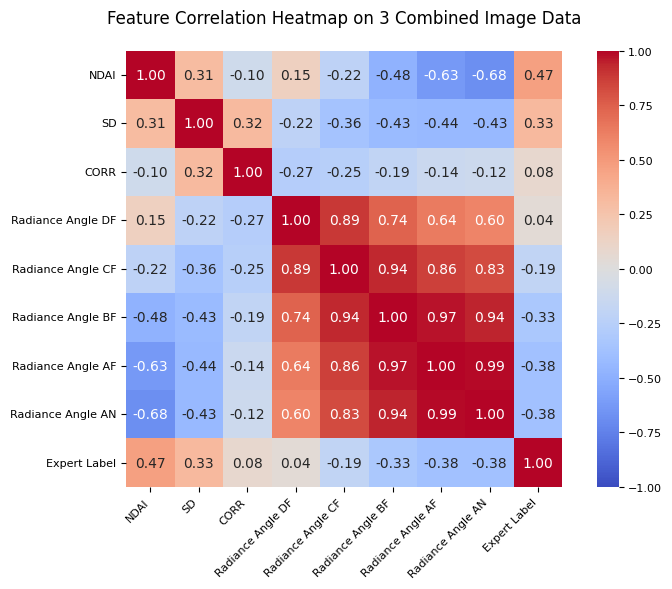

In [6]:
# Define column names for the dataset
columns = ["y_coordinate", "x_coordinate", "NDAI", "SD", "CORR", 
           "Radiance_angle_DF", "Radiance_angle_CF", "Radiance_angle_BF", 
           "Radiance_angle_AF", "Radiance_angle_AN", "expert_label"]

# Convert the list of image arrays (images_long) into a list of DataFrames
df_list = [pd.DataFrame(img, columns=columns) for img in images_long]

# Concatenate all DataFrames into a single DataFrame
df_combined = pd.concat(df_list, ignore_index=True)

# Compute correlation matrix (excluding spatial coordinates)
correlation_matrix = df_combined.drop(['x_coordinate', 'y_coordinate'], axis=1).corr()

new_labels = [
    "NDAI", "SD", "CORR", 
    "Radiance Angle DF", "Radiance Angle CF", "Radiance Angle BF", 
    "Radiance Angle AF", "Radiance Angle AN", "Expert Label"
]

# Set up the matplotlib figure for the heatmap
plt.figure(figsize=(8, 6))

# Create a heatmap using seaborn to visualize feature correlations
heatmap = sns.heatmap(correlation_matrix, 
            annot=True,           # Display correlation values on the heatmap
            cmap='coolwarm',      # Use a cool-to-warm color scheme
            center=0,             # Center the colormap at 0
            fmt='.2f',            # Format correlation values to 2 decimal places
            square=True,          # Ensure the plot is square-shaped
            vmin=-1, vmax=1,      # Set correlation range from -1 to 1
            xticklabels=new_labels,    # Set custom x-axis labels
            yticklabels=new_labels,
            annot_kws={'size': 10})    # Set custom y-axis labels

# Set title for the heatmap
plt.title('Feature Correlation Heatmap on 3 Combined Image Data', pad=20, fontsize=12)

plt.xticks(fontsize=8, rotation=45, ha="right")
plt.yticks(fontsize=8)   

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
# Adjust layout to ensure everything fits well
plt.tight_layout()

# Display the heatmap
plt.show()

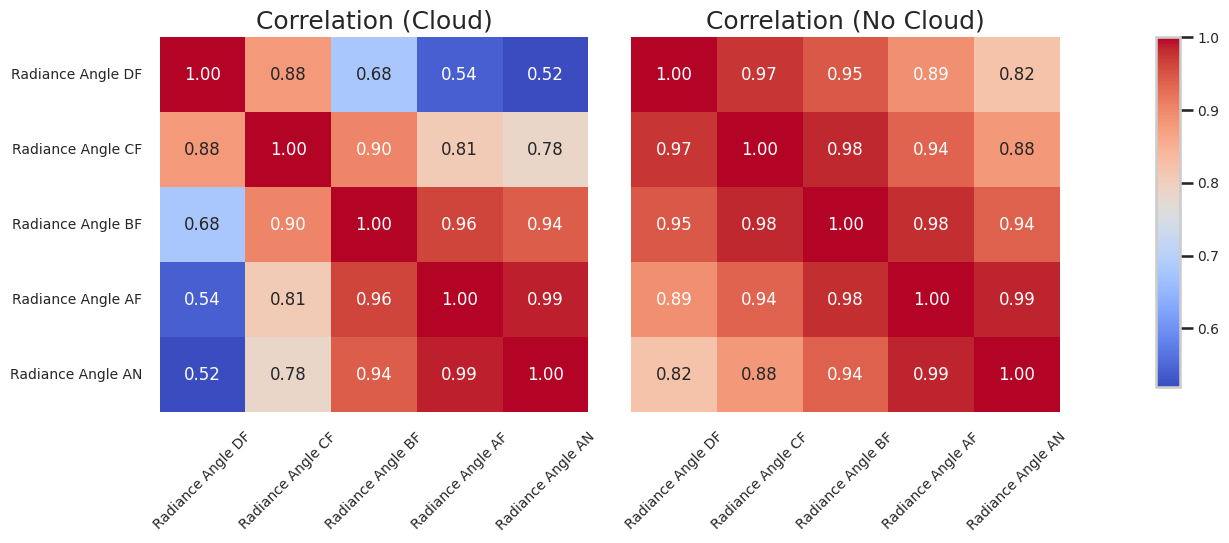

In [60]:
# Extract the radiance angle features (columns 5 to 10)
radiance = df_combined.iloc[:, 5:10]

# Extract cloud labels (last column)
cloud = df_combined.iloc[:, -1]

# Create a new DataFrame with radiance features and corresponding cloud labels
df = pd.DataFrame(radiance, columns=[
    "Radiance_angle_DF", "Radiance_angle_CF", "Radiance_angle_BF", 
    "Radiance_angle_AF", "Radiance_angle_AN"
])
df["Cloud"] = cloud  # Append cloud labels to the DataFrame

# Separate data based on cloud labels (1 = cloud, -1 = no cloud)
df_cloud = df[df["Cloud"] == 1].drop(columns=["Cloud"])  # Only cloud data
df_no = df[df["Cloud"] == -1].drop(columns=["Cloud"])  # Only non-cloud data

# Compute correlation matrices for cloud and non-cloud regions
corr_cloud = df_cloud.corr()
corr_no = df_no.corr()

# Determine the min and max values for color scaling to keep both heatmaps comparable
vmin = min(corr_cloud.min().min(), corr_no.min().min())
vmax = max(corr_cloud.max().max(), corr_no.max().max())

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

new_labels = [
    "Radiance Angle DF", "Radiance Angle CF", "Radiance Angle BF", 
    "Radiance Angle AF", "Radiance Angle AN"
]

# Plot heatmap for cloud regions
im_cloud  = sns.heatmap(
    corr_cloud, annot=True, 
    cmap="coolwarm", fmt=".2f", ax=axes[0], 
    vmin=vmin, vmax=vmax,
    xticklabels=new_labels,
    yticklabels=new_labels,
    cbar=False,
    annot_kws={'size': 12})

axes[0].set_title("Correlation (Cloud)")
axes[0].tick_params(axis="x", rotation=45, labelsize=10)  # Rotate x-axis labels and adjust size
axes[0].tick_params(axis="y", labelsize=10)  # Adjust y-axis label size

# Plot heatmap for non-cloud regions
im_no = sns.heatmap(
    corr_no, annot=True, 
    cmap="coolwarm", fmt=".2f", ax=axes[1], 
    vmin=vmin, vmax=vmax,
    xticklabels=new_labels,
    yticklabels=new_labels,
    cbar=False,
    annot_kws={'size': 12})

axes[1].set_title("Correlation (No Cloud)")
axes[1].tick_params(axis="x", rotation=45, labelsize=10)  # Rotate x-axis labels and adjust size
axes[1].set_ylabel("")
axes[1].tick_params(left=False, labelleft=False)

# Create a single colorbar on the right
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [x, y, width, height]
fig.colorbar(im_cloud.get_children()[0], cax=cbar_ax)
cbar_ax.set_label("Correlation Value")
cbar_ax.tick_params(labelsize=10)

plt.subplots_adjust(left=0.05, right=0.4, bottom=0.1, top=0.85, wspace=0.1)

# Adjust layout for better visualization
fig.subplots_adjust(right=0.8) 

# Display the heatmaps
plt.show()


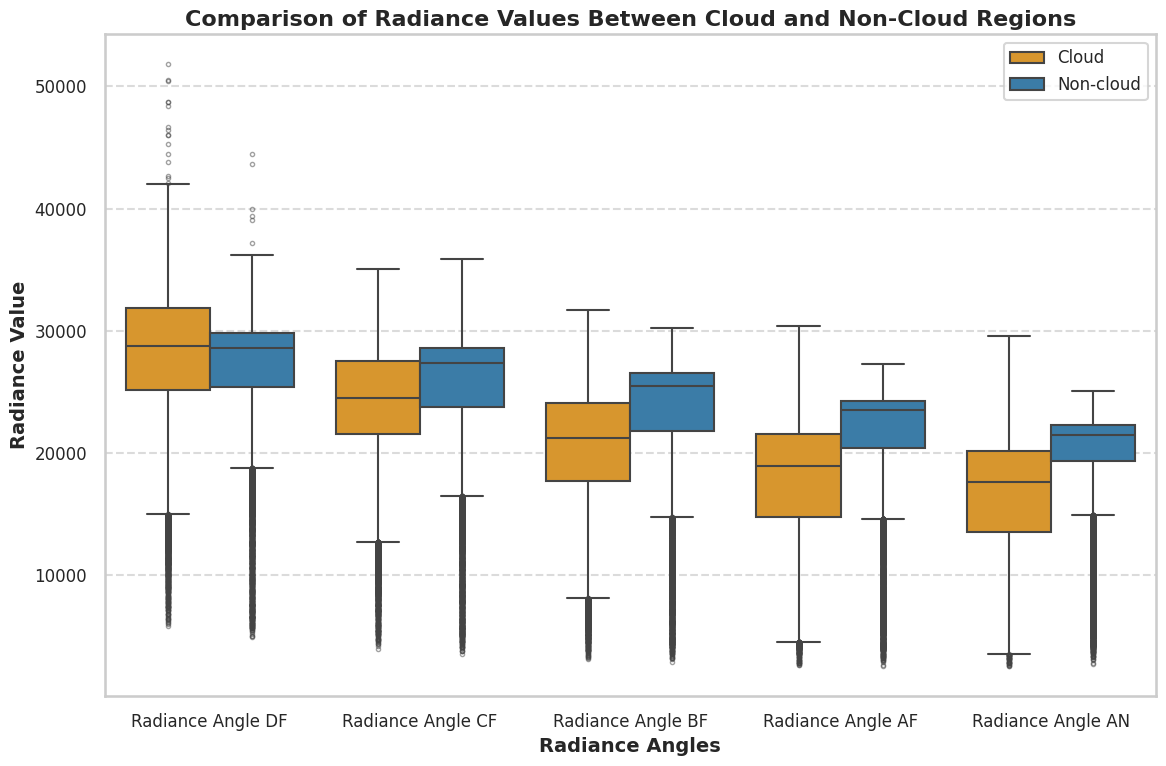

In [62]:
# Create DataFrame with selected radiance angle features
df = pd.DataFrame(radiance, columns=[ 
    "Radiance_angle_DF", "Radiance_angle_CF", "Radiance_angle_BF", 
    "Radiance_angle_AF", "Radiance_angle_AN"
])

# Append cloud labels to the DataFrame
df["Label"] = cloud

# Remove unlabeled data (where Label == 0)
df = df[df["Label"] != 0]

# Replace numerical labels with categorical values
df["Label"] = df["Label"].replace({1: "Cloud", -1: "Non-cloud"})

# Convert DataFrame into long format for seaborn boxplot
df_melted = df.melt(id_vars=["Label"], var_name="Radiance Type", value_name="Radiance Value")

# Create a boxplot to compare radiance values between cloud and non-cloud regions
plt.figure(figsize=(12, 8))

# Use a different color palette and adjust style for clarity
sns.boxplot(x="Radiance Type", y="Radiance Value", hue="Label", data=df_melted,
            palette={"Cloud": "#f39c12", "Non-cloud": "#2980b9"},  # More vibrant colors
            linewidth=1.5,  # Thicker lines for better visibility
            width=0.8,  # Adjust box width for a better visual appearance
            flierprops=dict(marker='o', color='black', markersize=3, alpha=0.5))  

# Set plot title and axis labels
plt.title("Comparison of Radiance Values Between Cloud and Non-Cloud Regions", fontsize=16, fontweight='bold')
plt.xlabel("Radiance Angles", fontsize=14, fontweight='bold')
plt.ylabel("Radiance Value", fontsize=14, fontweight='bold')

# Customize legend position and title
plt.legend(loc='upper right', fontsize=12, title_fontsize=14)

# Improve the x and y axis labels with more space and rotated x-axis labels
new_labels = [
    "Radiance Angle DF", "Radiance Angle CF", "Radiance Angle BF", 
    "Radiance Angle AF", "Radiance Angle AN"
]
plt.xticks(ticks=range(5), labels=new_labels, fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid lines for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better spacing and visibility
plt.tight_layout()
plt.show()


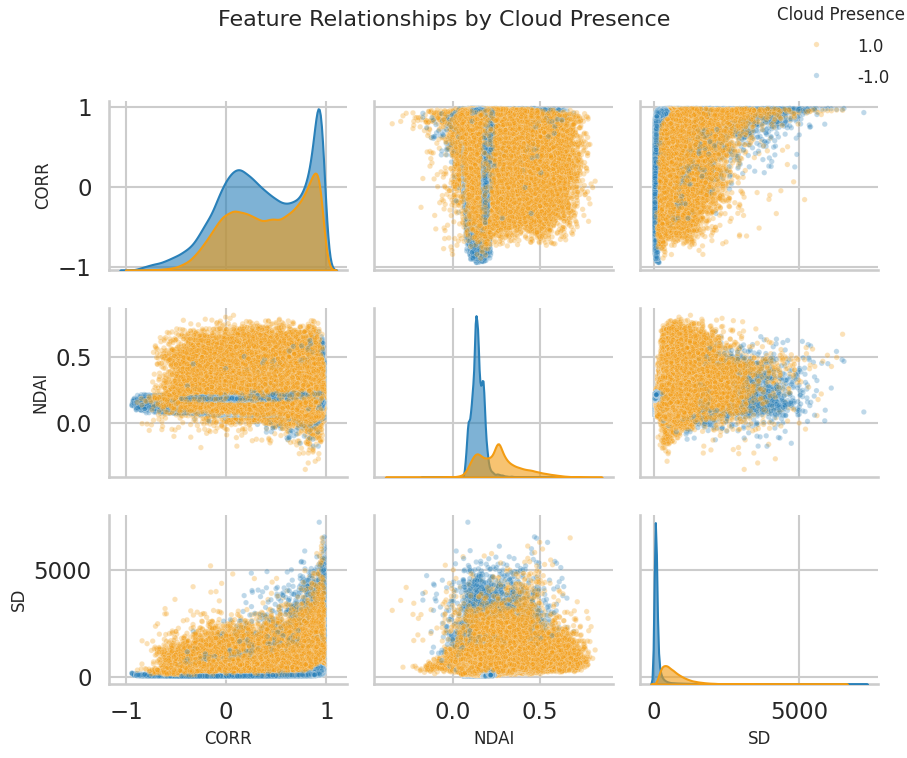

In [38]:
current_style = sns.axes_style()
current_context = sns.plotting_context()

sns.set(style="whitegrid", context="talk")

df_combined['expert_label'] = df_combined['expert_label'].astype(str)

# Create pairplot focusing on key features
g = sns.pairplot(df_combined[df_combined['expert_label']!="0.0"], 
                 vars=["CORR", "NDAI", "SD"],  # Key features for analysis
                 hue="expert_label",           # Color by cloud presence
                 palette={"1.0": "#f39c12", "-1.0": "#2980b9"},           # Red for clouds, blue for no clouds
                 diag_kind="kde",
                 plot_kws={'alpha': 0.3, 's': 15},
                 diag_kws={'fill': True, 'alpha': 0.6})

# Enhance the plot
g.fig.suptitle("Feature Relationships by Cloud Presence", y=1.02, fontsize=16)

# Add descriptive labels
for ax in g.axes.flat:
    if ax is not None:
        if ax.get_xlabel():
            ax.set_xlabel(ax.get_xlabel(), fontsize=12)
        if ax.get_ylabel():
            ax.set_ylabel(ax.get_ylabel(), fontsize=12)

legend = g._legend
legend.set_title("Cloud Presence")
legend.get_title().set_fontsize(12)
for text in legend.texts:
    text.set_fontsize(12)

legend.set_bbox_to_anchor((0.82, 1.03))  # Positioning the legend outside the plot
legend.set_loc('upper left')

plt.tight_layout()
plt.show()

sns.set(style=current_style, context=current_context)

## Part 2

In [ ]:
# Define column names for the dataset
columns = ["y_coordinate", "x_coordinate", "NDAI", "SD", "CORR", 
           "Radiance_angle_DF", "Radiance_angle_CF", "Radiance_angle_BF", 
           "Radiance_angle_AF", "Radiance_angle_AN", "expert_label"]

# Convert the list of image arrays (images_long) into a list of DataFrames
df_list = [pd.DataFrame(img, columns=columns) for img in images_long]

# Concatenate all DataFrames into a single DataFrame
df_combined = pd.concat(df_list, ignore_index=True)

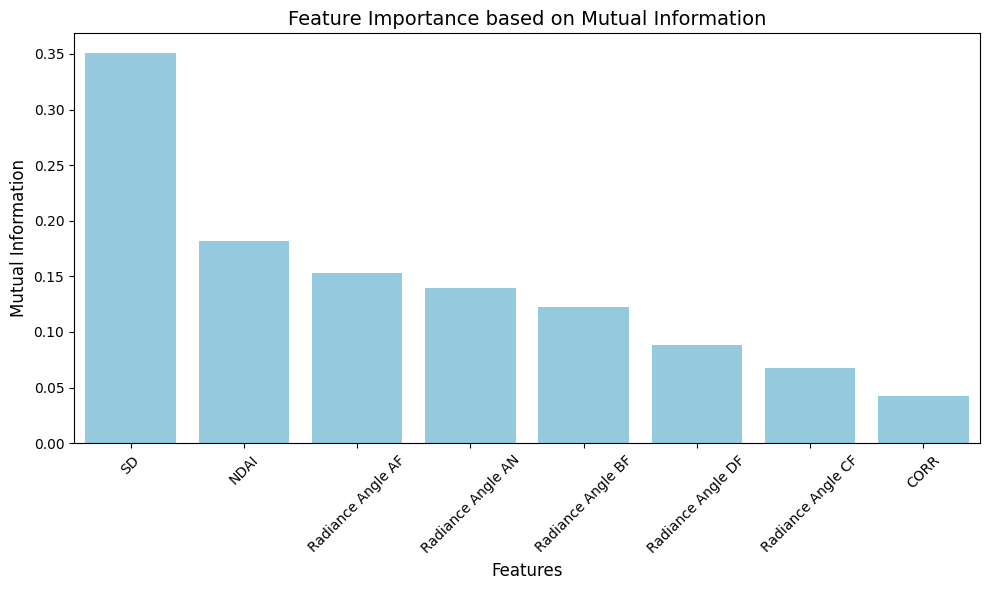

In [14]:
# Point-Biserial Correlation Coefficient
X = df_combined.drop(['x_coordinate', 'y_coordinate','expert_label'], axis=1)
y = df_combined.iloc[:, -1]   # Label

from sklearn.feature_selection import mutual_info_classif, f_classif
from scipy.stats import pointbiserialr

pb_corr = {}
for col in X.columns:
    corr, pval = pointbiserialr(X[col], y)
    pb_corr[col] = round(corr, 4)

pb_corr_df = pd.DataFrame.from_dict(pb_corr, orient='index', columns=['Point-Biserial Corr'])

# Mutual Information Score (captures non-linear relationships)
mi_scores = mutual_info_classif(X, y, discrete_features=False)
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores}).set_index('Feature')

# ANOVA F-test
f_scores, p_vals = f_classif(X, y)
anova_df = pd.DataFrame({'Feature': X.columns, 'F-score': f_scores, 'p-value': p_vals}).set_index('Feature')

# Combine and display all results
summary = pb_corr_df.join(mi_df).join(anova_df)

# Sort and view the results
summary_sorted = summary.sort_values(by='Mutual Information', ascending=False)

new_labels = [
    "SD", "NDAI", "Radiance Angle AF", "Radiance Angle AN", "Radiance Angle BF",
    "Radiance Angle DF", "Radiance Angle CF", "CORR"
]

# Visualization: Heatmap + Barplot
plt.figure(figsize=(10,6))
sns.barplot(data=summary_sorted.reset_index(), x='index', y='Mutual Information', color='skyblue')

plt.xticks(ticks=range(8), labels=new_labels, rotation=45, fontsize=10)
plt.yticks(fontsize=10)  
plt.xlabel("Features", fontsize=12)  
plt.ylabel("Mutual Information", fontsize=12)  
plt.title("Feature Importance based on Mutual Information", fontsize=14)  

plt.tight_layout()  
plt.show()



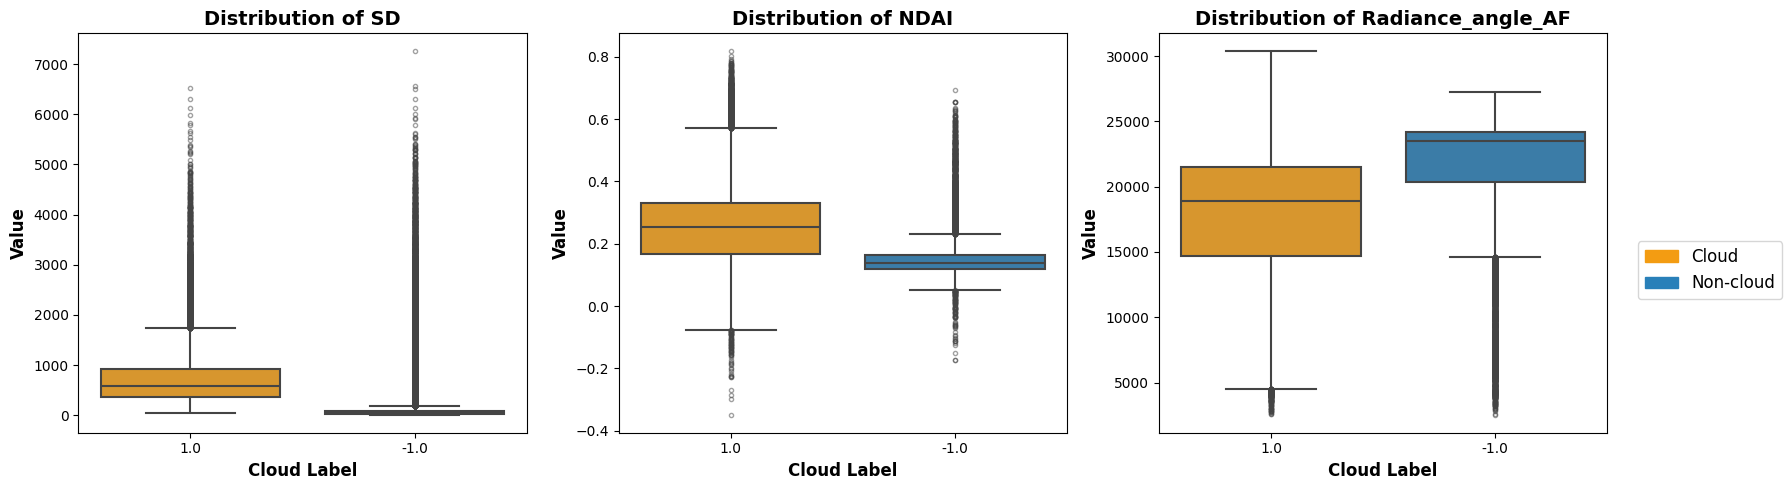

In [34]:
# Create the DataFrame and prepare the data
df_filtered = df_combined[df_combined['expert_label'].isin([-1.0, 1.0])]

top_feats = summary_sorted.index[:3]

# Set up the figure and axes for the boxplot
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Plot each feature in a separate boxplot
for i, feat in enumerate(top_feats):
    sns.boxplot(x="expert_label", y=feat, data=df_filtered, hue="expert_label", palette={1.0: "#f39c12", -1.0: "#2980b9"}, 
                linewidth=1.5, width=0.8, ax=axes[i], legend=False,
                flierprops=dict(marker='o', color='black', markersize=3, alpha=0.5),
                order=[1.0, -1.0])  # Custom flier settings
    
    axes[i].set_title(f"Distribution of {feat}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("Cloud Label", fontsize=12, fontweight='bold')
    axes[i].set_ylabel("Value", fontsize=12, fontweight='bold')

handles = [Rectangle((0, 0), 1, 1, color="#f39c12"),  # Cloud (Orange)
           Rectangle((0, 0), 1, 1, color="#2980b9")]  # Non-cloud (Blue)
labels = ['Cloud', 'Non-cloud']

plt.legend(handles, labels, bbox_to_anchor=(1.05, 0.5), fontsize=12)
# Adjust the layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()